In [1]:
import numpy as np
import brainflow
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, AggOperations
import matplotlib.pyplot as plt
import pandas as pd
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
import time

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds


[[     0.    45997.52  46077.2  ...  43556.62  43561.78  43535.81]
 [     0.    37487.45  37578.29 ...  37944.23  37951.61  37910.48]
 [     0.   -22369.71 -22259.92 ... -22341.8  -22375.53 -22395.15]
 ...
 [     0.   -24777.78 -24711.8  ... -24640.09 -24663.58 -24637.92]
 [     0.   -10055.49  -9977.57 ...  -9024.16  -9063.45  -9055.83]
 [     0.    -3746.69  -3650.2  ...  -3427.68  -3476.52  -3487.16]]
Data From the File
        0         1         2         3         4         5         6    \
0  0.000000  0.045998  0.046077  0.046158  0.046112  0.046003  0.046050   
1  0.046058  0.046033  0.046068  0.046083  0.046044  0.046025  0.046064   
2  0.045932  0.045942  0.045994  0.045976  0.045938  0.045950  0.045997   
3  0.045956  0.045976  0.046010  0.045988  0.045945  0.045964  0.046013   
4  0.043491  0.043543  0.043578  0.043544  0.043517  0.043564  0.043614   
5  0.043286  0.043339  0.043352  0.043327  0.043318  0.043371  0.043390   
6  0.041734  0.041812  0.041849  0.041843  0.041

C:\Users\nad_a\AppData\Local\Temp\ipykernel_24348\2069197223.py:48: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(average=True)
c:\Users\nad_a\mne-python\1.7.0_0\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


<RawArray | 8 x 29999 (120.0 s), ~1.8 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: FC3, FCz, FC4, C3, Cz, C4, CP3, CPz
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


c:\Users\nad_a\mne-python\1.7.0_0\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Using qt as 2D backend.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


C:\Users\nad_a\AppData\Local\Temp\ipykernel_24348\2069197223.py:69: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.6s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


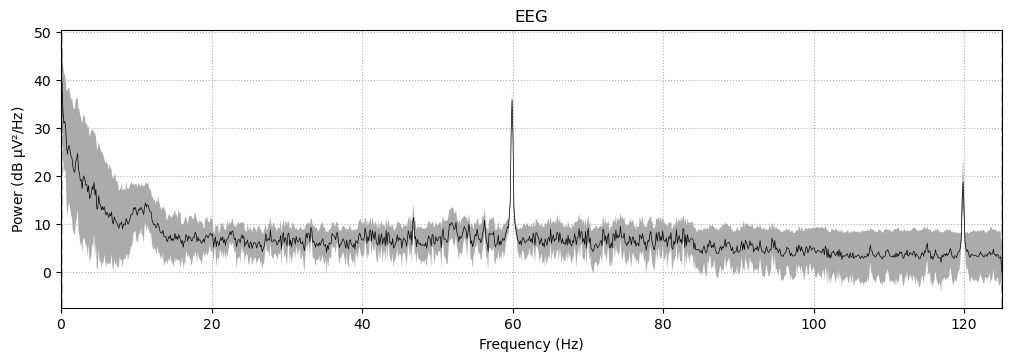

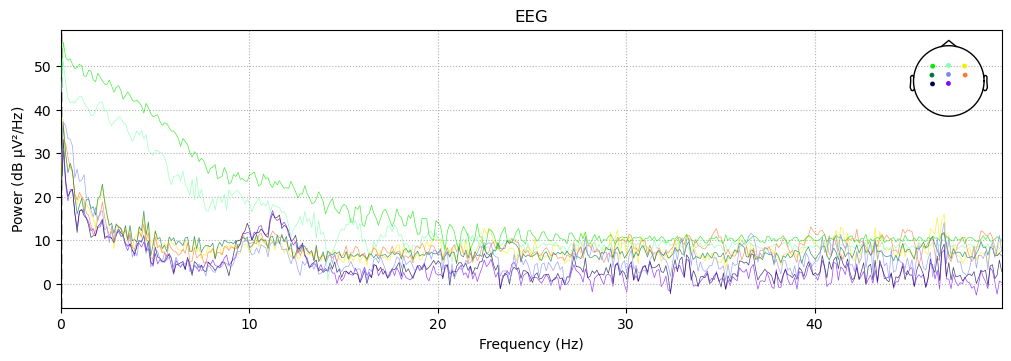

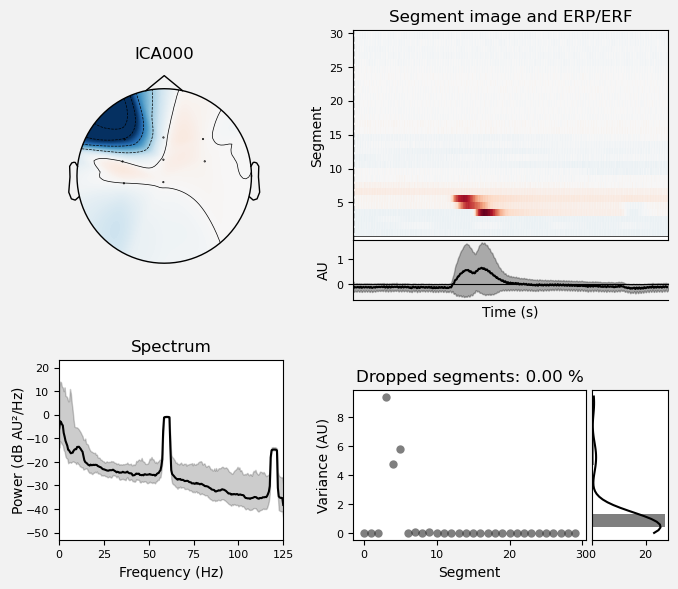

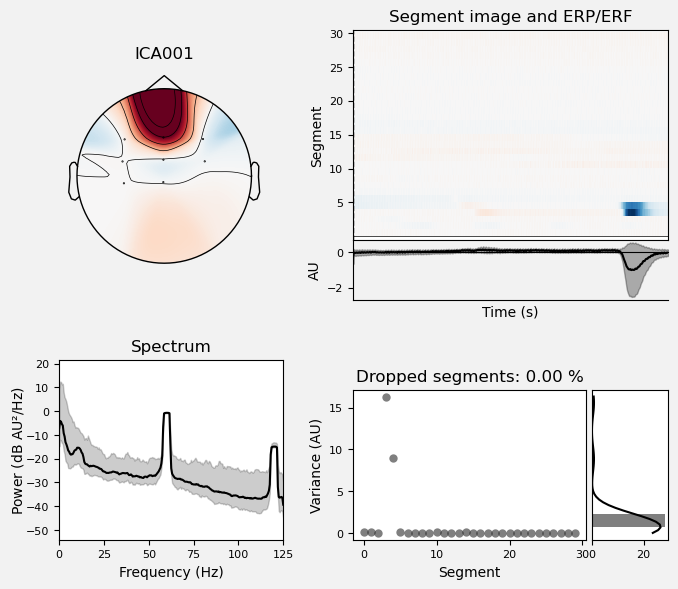

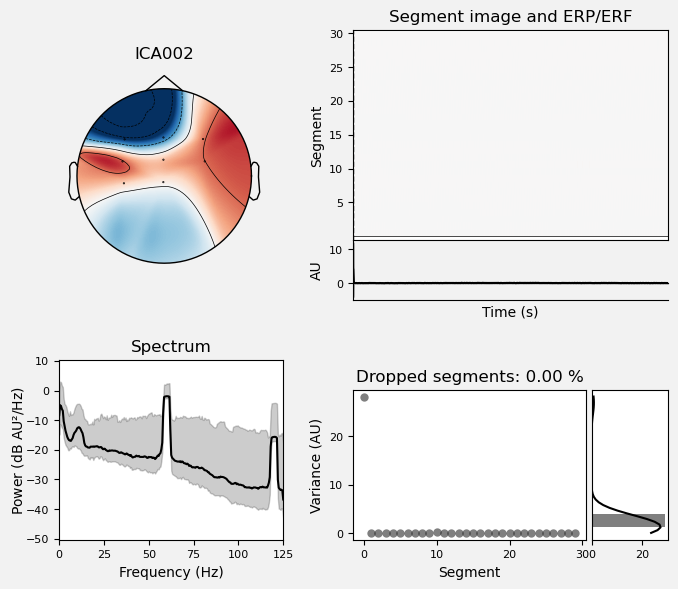

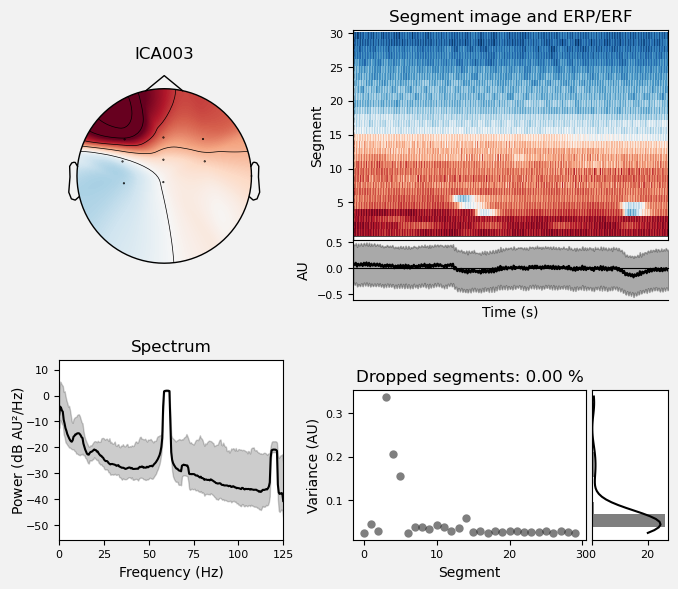

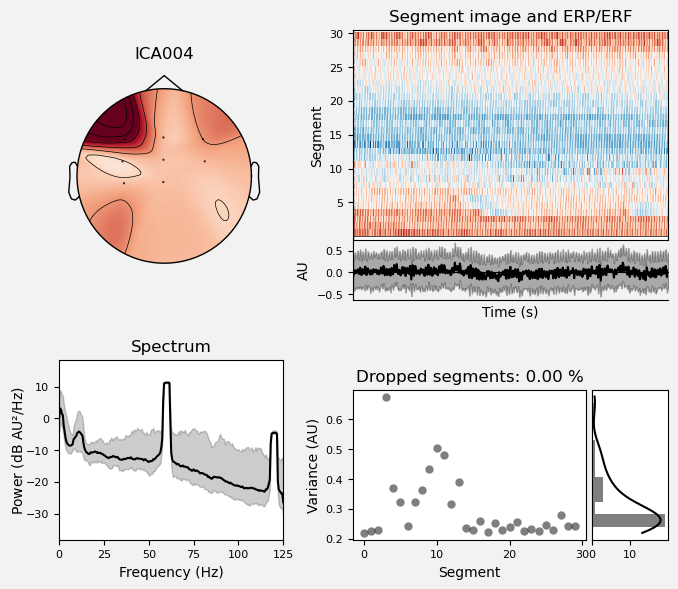

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

Channels marked as bad:
none


In [2]:

# Especifica el path de tu archivo de OpenBCI
file_path = 'OpenBCI_GUI-v5-meditation.txt'

# Leer el archivo de texto
data = pd.read_csv(file_path, comment='%', header=None)

# Extraer las columnas relevantes (suponiendo que las primeras 8 columnas después de la columna de índice son los datos de EEG) y todas las filas
eeg_data = data.iloc[1:30000, 1:9]
eeg_trans = pd.DataFrame(np.transpose(eeg_data))
eeg = eeg_trans.to_numpy()


# Verifica la estructura de los datos

# demo for data serialization using brainflow API, we recommend to use it instead pandas.to_csv()

print(eeg)

eeg_channels=[1, 2, 3, 4, 5, 6, 7, 8]
eeg_data = eeg / 1000000 


eeg_trans = pd.DataFrame(np.transpose(eeg_data))
eeg_trans = np.ascontiguousarray(eeg_trans)
DataFilter.write_file(eeg_trans, 'test.csv', 'w')  # use 'a' for append mode
restored_data = DataFilter.read_file('test.csv')
restored_df = pd.DataFrame(np.transpose(restored_data))
print('Data From the File')
print(restored_df.head(10))


# Creating MNE objects from brainflow data arrays
ch_types = ['eeg'] * len(eeg_channels)
ch_names = [
    "FC3",
    "FCz",
    "FC4",
    "C3",
    "Cz",
    "C4",
    "CP3",
    "CPz"
]
sfreq = 250
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)
# its time to plot something!
raw.plot_psd(average=True)
plt.savefig('psd.png')

print(raw)
print(raw.info)


# Establecer cómo están conectados los electrodos (para que se puedan graficar los ICA)
montage = mne.channels.make_standard_montage('standard_1005')  # Opcional: montaje estándar de electrodos
raw.set_montage(montage)


raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=8)

# Here we'll crop to 60 seconds and drop gradiometer channels for speed
raw.crop(tmax=60.0).pick(picks=["mag", "eeg", "stim", "eog"])
raw.load_data()

# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=8, random_state=97, max_iter=1000)
ica.fit(raw)

ica.plot_properties(raw)


